In [1]:
#!pip install torch

In [2]:
#!pip install wordcloud

In [3]:
#!pip install transformers

# Проект для «Викишоп» c BERT

## Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.  
Постройте модель со значением метрики качества F1 не меньше 0.75.

## Описание данных

Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.


# 1. Загрузим и подготовим данные

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform as sp_randfloat
from scipy.stats import randint as sp_randint 


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

import re
import torch
import transformers as ppb
from tqdm import notebook 
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
try:
    df = pd.read_csv('/Users/kostyabykov/Downloads/toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
print("Кол-во дубликатов:", df.duplicated().sum())
print("Кол-во пропущенных значений:", df.isnull().sum().sum())

Кол-во дубликатов: 0
Кол-во пропущенных значений: 0


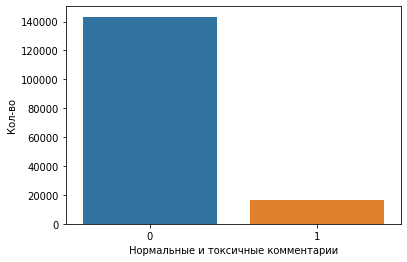

0    143346
1     16225
Name: toxic, dtype: int64

Доля токсичных комментариев: 10.167888%


In [9]:
# Исследуем баланс классов
sns.countplot(x = 'toxic', data = df)
plt.xlabel('Нормальные и токсичные комментарии')
plt.ylabel('Кол-во')
plt.show()
print(df.toxic.value_counts())
print('\nДоля токсичных комментариев: {:%}'.format(df[df['toxic'] == 1].shape[0] / df.shape[0]))

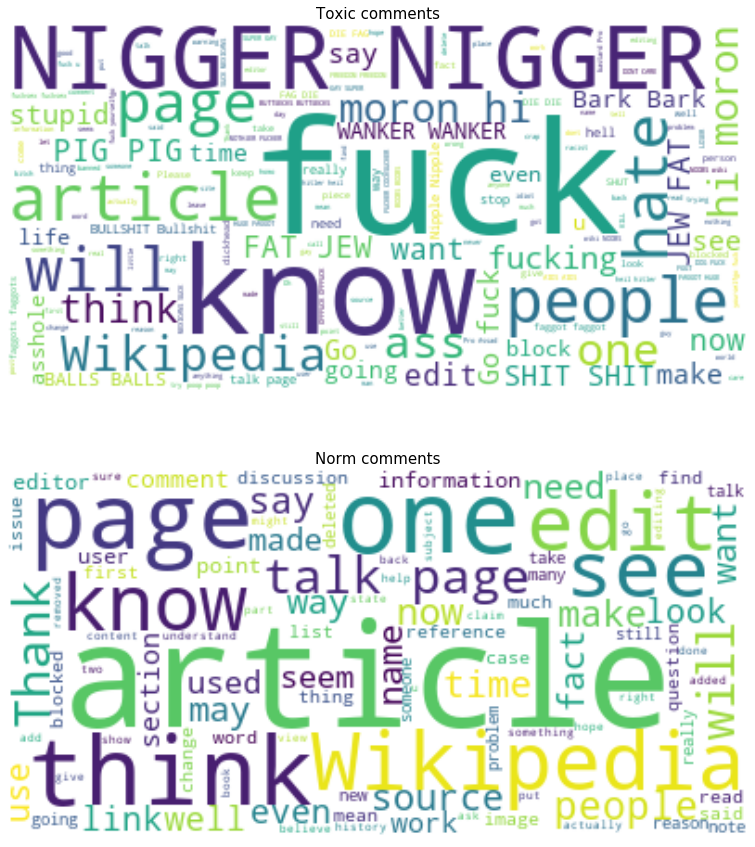

In [10]:
# Визуализируем часто встречающиеся слова в каждой категории
df_toxic = df[df['toxic'] == 1]
df_toxic.text
toxic = " ".join(x for x in df_toxic.text)

df_norm = df[df['toxic'] == 0]
df_norm.text
norm = " ".join(x for x in df_norm.text)

fig, ax = plt.subplots(2, 1, figsize  = (20,15))

wordcloud_toxic = WordCloud(background_color="white").generate(toxic)
wordcloud_norm = WordCloud(background_color="white").generate(norm)

ax[0].imshow(wordcloud_toxic, interpolation='bilinear')
ax[0].set_title('Toxic comments',fontsize=15)
ax[0].axis('off')
ax[1].imshow(wordcloud_norm, interpolation='bilinear')
ax[1].set_title('Norm сomments',fontsize=15)
ax[1].axis('off')
plt.show()

In [11]:
# избавимся от символа /n и прочих лишних символов
df['text'] = df['text'].apply(lambda x: x.replace('\n',' '))
def clear(text):  
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return ' '.join(text.split())
df['text'] = pd.DataFrame(df['text'].apply(lambda x: clear(x)))

In [12]:
# для последующего обучения модели требуется избавиться от дисбаланса классов, воспользуемся методом downsampling
df_down = df.copy()
#df_down[df_down['toxic']==0] = df_down[df_down['toxic']==0].sample(frac=0.13,random_state=12345)
#df_down = df_down.dropna().reset_index(drop=True)
df_down['toxic'] = df_down['toxic'].astype(int)
df_down['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

## Вывод

Мы пришли к следующим выводам:
* Датафрейм состоит из 159 тыс строк
* Доля токсичных комментариев составила
* Мы избавились от лишних символов

## 2. BERT

In [13]:
# Создадим уменьшенный датафрейм для передачи его в Берт
df_bert_sample = df_down.sample(4000, random_state=12345).reset_index(drop=True)
print("доля токсичных комментариев:", df_bert_sample[df_bert_sample['toxic'] == 1].shape[0]/df_bert_sample.shape[0])

доля токсичных комментариев: 0.0945


In [14]:
# импортируем обученный уже DistilBERT (пример https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# токенизируем текст
tokenized = df_bert_sample['text'].apply((lambda x: tokenizer.encode(x[:512], add_special_tokens=True)))

In [16]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [17]:
attention_mask = np.where(padded != 0, 1, 0)

In [18]:
padded.shape

(4000, 174)

In [19]:
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/80 [00:00<?, ?it/s]

In [20]:
X = np.concatenate(embeddings)
y = df_bert_sample['toxic']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12345, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=12345, test_size=0.5)

In [22]:
results_bert = []
results_no_bert = []

### Logistic Regression

In [23]:
logr = LogisticRegression(class_weight = 'balanced')

logr.fit(X_train, y_train)

logr_prediction = logr.predict(X_valid)
l_p_test = logr.predict(X_test)

print('F1 score log.reg valid:',f1_score(y_valid,logr_prediction))
print('F1 score log.reg test:',f1_score(y_test,logr.predict(X_test)))
results_bert.append(f1_score(y_test,l_p_test))

F1 score log.reg valid: 0.6382978723404256
F1 score log.reg test: 0.655367231638418


### CatBoost

In [24]:
cat = CatBoostClassifier(verbose=False, random_state=12345, depth = 8, iterations = 99, learning_rate = 0.05568836266437094)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_valid)
cat_pr_test = cat.predict(X_test)

results_bert.append(f1_score(y_test,cat_pr_test))
print('F1 score Catboost на валид выборке:', f1_score(y_valid, cat_pred))
print('F1 score Catboost на тестовой выборке:', f1_score(y_test, cat_pr_test))


F1 score Catboost на валид выборке: 0.6445497630331753
F1 score Catboost на тестовой выборке: 0.5283018867924528


### LGBMClassifier

In [25]:
lgbm = lgb.LGBMClassifier()#random_state=12345, silent=True, min_child_samples = 164, 
                          #min_child_weight = 1e-05, num_leaves = 40, reg_alpha = 2, reg_lambda = 0.1)

lgbm.fit(X_train, y_train)
lgbm_prediction = lgbm.predict(X_valid)
lgbm_pr_test = lgbm.predict(X_test)

print('F1 score LGBMClassifier valid:',f1_score(y_valid,lgbm_prediction))
print('F1 score LGBMClassifier test:',f1_score(y_test,lgbm.predict(X_test)))
results_bert.append(f1_score(y_test,lgbm.predict(X_test)))

F1 score LGBMClassifier valid: 0.6575342465753424
F1 score LGBMClassifier test: 0.5535714285714286


### XGBClassifier

In [26]:
model = xgb.XGBClassifier()#subsample = 0.9, silent=True, reg_lambda=0.1, n_estimators=500, 
                          #min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0,
                          #colsample_bytree=0.8, colsample_bylevel=0.9, refit=True, verbose=False)

model.fit(X_train, y_train)
val_pred = model.predict(X_valid)
pred = model.predict(X_test)
results_bert.append(f1_score(y_test,pred))
print('\nF1 Score XGBClassifier на валид выборке:',f1_score(y_valid, val_pred))
print('\nF1 Score XGBClassifier на тестовой выборке:',f1_score(y_test, pred))

[11:14:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

F1 Score XGBClassifier на валид выборке: 0.663677130044843

F1 Score XGBClassifier на тестовой выборке: 0.5565217391304348


In [27]:
bert = pd.DataFrame(data=results_bert, index=[['Logistic Regression','CatBoost','LGBMClassifier','XGBClassifier']], columns = ['F1_score'])

In [28]:
bert

,F1_score
Logistic Regression,0.655367
CatBoost,0.528302
LGBMClassifier,0.553571
XGBClassifier,0.556522


### Вывод

Мы импортировали обученный Bert, токенизировали текст и преобразовали его в эмбеддинги. На выборке из 4000 значений лучше себя проявил Logistic Regression - f1 = 0.65

## Без Bert'a

In [29]:
df_down_sample = df_down
#df_down_sample = df_down.sample(500, random_state=12345).reset_index(drop=True)
print("доля токсичных комментариев:", df_down_sample[df_down_sample['toxic'] == 1].shape[0]/df_down_sample.shape[0])

доля токсичных комментариев: 0.10167887648758234


```python 
nltk.download('stopwords')
nltk.download('wordnet')
```

In [30]:
def lemmatize(text):
    m = WordNetLemmatizer()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
    
        
    return lemm_text

In [31]:
corpus = list(df_down_sample['text'].apply(lambda x: lemmatize(clear(x))).values.astype('U'))

In [32]:
data = pd.DataFrame({'lemma': corpus, 'toxic': df_down_sample['toxic']})

In [33]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data['lemma'], data['toxic'], random_state=12345, test_size=0.2)

In [34]:
X_valid2, X_test2, y_valid2, y_test2 = train_test_split(X_test2, y_test2, random_state=12345, test_size=0.5)

In [35]:
stopwords = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words = stopwords)
X_train2 = count_tf_idf.fit_transform(X_train2)
X_valid2 = count_tf_idf.transform(X_valid2)
X_test2 = count_tf_idf.transform(X_test2)

### LogisticRegression

In [36]:
logr = LogisticRegression(class_weight = 'balanced')

logr.fit(X_train2, y_train2)

logr_prediction = logr.predict(X_valid2)
l_p_test = logr.predict(X_test2)

print('F1 score log.reg valid:',f1_score(y_valid2,logr_prediction))
print('F1 score log.reg test:',f1_score(y_test2,logr.predict(X_test2)))
results_no_bert.append(f1_score(y_test2,l_p_test))

F1 score log.reg valid: 0.7552182163187855
F1 score log.reg test: 0.7555555555555555


### LGBMClassifier

In [37]:
lgbm = lgb.LGBMClassifier()

lgbm.fit(X_train2, y_train2)
lgbm_prediction = lgbm.predict(X_valid2)


print('F1 score LGBMClassifier valid:',f1_score(y_valid2,lgbm_prediction))
print('F1 score LGBMClassifier test:',f1_score(y_test2,lgbm.predict(X_test2)))
results_no_bert.append(f1_score(y_test2,lgbm.predict(X_test2)))

F1 score LGBMClassifier valid: 0.7498213009292352
F1 score LGBMClassifier test: 0.7401978746793698


### XGBClassifier

In [38]:
xgbc = xgb.XGBClassifier()

xgbc.fit(X_train2, y_train2)
xgbc_pred = xgbc.predict(X_valid2)

print('F1 score XGBClassifier valid:',f1_score(y_valid2,xgbc_pred))
print('F1 score XGBClassifier test:',f1_score(y_test2,xgbc.predict(X_test2)))
results_no_bert.append(f1_score(y_test2,xgbc.predict(X_test2)))

[11:15:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score XGBClassifier valid: 0.7299484915378954
F1 score XGBClassifier test: 0.7182195397963033


In [39]:
no_bert = pd.DataFrame(data = results_no_bert,columns = ['F1_score'], index = [['Logistic Regression', 'LGBMClassifier', 'XGBClassifier']])


In [40]:
itog = pd.concat([bert, no_bert], axis=1)
itog.columns = ['bert', 'not_bert']
itog

,bert,not_bert
CatBoost,0.528302,NaN
LGBMClassifier,0.553571,0.740198
Logistic Regression,0.655367,0.755556
XGBClassifier,0.556522,0.718220


### Вывод
* Мы лемматизировали и очистили текст от лишних символов
* Сделали текст из очищенного и лемматизированного текста
* Векторизировали значения и оценили важность слов с помощью TF-IDF
* Лучший результат я смог получить при использовании Логистической регрессии на полной выборке. 
* При использовании катбуста умирал кернелл, даже при выборке в 500 значений, а при попытке использовать подбор параметров умирал кернелл после всех моделей

## Общий вывод

На этапе анализа данных мы пришли к следующим выводам:
* Датафрейм состоит из 159 тыс строк
* Доля токсичных комментариев составила
* Мы избавились от лишних символов

На этапе работы с Bert:
* Мы импортировали обученный DistilBERT
* Токенизировали текст и преобразовали его в эмбеддинги 
* На выборке из 4000 значений лучше себя проявил Logistic Regression - f1 = 0.65

Процесс работы без Bert'a:
* Мы лемматизировали и очистили текст от лишних символов
* Сделали текст из очищенного и лемматизированного текста
* Векторизировали значения и оценили важность слов с помощью TF-IDF
* Лучший результат я смог получить при использовании Логистической регрессии на полной выборке. 
* При использовании катбуста умирал кернелл, даже при выборке в 500 значений, а при попытке использовать подбор параметров умирал кернелл после всех моделей

Можно сделать итоговый вывод, что классический подход справился лучше BERT, модель логистической регрессии была лучше других моделей в обоих случаях, поэтому я рекомендовал бы использовать ее.